## This notebook demonstrates typical usages of OSCAR
### Introduction

An "(energy) landscape" of a variational quantum algorithm (VQA) is the ensemble of objective function values over the parameter space, where each value is the expectation of measuring the problem Hamiltonian with the variational ansatz under the corresponding parameters. OSCAR exploits landscapes to provide VQA debugging featuers.

In OSCAR, the `oscar.Landscape` class uses a discretized grid over parameters in given ranges ([#Landscape](#landscape)), where the grid values are calculated by an `oscar.BaseExecutor` ([#Executor](#executor)). To speed up this grid generation process, OSCAR provides the option to approximate the grid values using only a small fraction of samples ([#Reconstruction](#reconstruction)). Additionally, OSCAR can interpolate the grid points to provide a continuous function approximating the landscape for instant optimization runs ([#Interpolation](#interpolation)), thus enabling highly efficient [#Optimization configuration benchmarking](#optimization-configuration-benchmarking) for choosing optimizers, their hyperparameters, initialization strategies, and more.

### Landscape

Define the landscape with parameter resolutions (granularity) and parameter bounds.
The order of the parameters corresponds to their order in the VQA ansatz definition. In the case of qiskit QAOA, the order is all betas and then all gammas.

In [1]:
from oscar import Landscape
from math import pi

resolution = [64, 64]
bounds = [(-pi / 4, pi / 4), (0, pi / 2)]
landscape = Landscape(resolution, bounds)

### Executor
#### Custom Executor

An executor can be easily constructed with a user-defined function that outputs the value of given input parameters.

In [2]:
from __future__ import annotations
from collections.abc import Sequence
from oscar import CustomExecutor


def f(params: Sequence[float]) -> float:
    ...


custom_executor = CustomExecutor(f)

#### Qiskit Executor

OSCAR also provides an executor that works with Qiskit problem and VQA classes.
As an example, let's solve a 3-regular graph MaxCut problem with QAOA. First, define the problem of interest with `qiskit_optimization` (or `qiskit_finance`, `qiskit_nature`, or `docplex.mp` for more problems). These packages are not OSCAR's dependencies and need to be manually installed.

In [3]:
# %pip install networkx qiskit_optimization

In [4]:
import networkx as nx
from qiskit_optimization.applications import Maxcut

n = 8
graph = nx.random_regular_graph(3, n, 42)
problem = Maxcut(graph).to_quadratic_program()
H, offset = problem.to_ising()  # construct the Hamiltonian

Define the desired Qiskit VQA.

algorithm = NewQAOA(
    Sampler(
        backend_options={"method": "statevector"},
        run_options={"shots": None},
    ),
    COBYLA(),
)

In [5]:
# %pip install qiskit_aer

In [6]:
# # Old
# from qiskit_aer import AerSimulator
# from qiskit.algorithms import QAOA as OldQAOA
# from qiskit.algorithms.optimizers import COBYLA

# algorithm = OldQAOA(COBYLA(), quantum_instance=AerSimulator())

In [7]:
# New
from qiskit_aer.primitives import Sampler
from qiskit.algorithms.minimum_eigensolvers import QAOA as NewQAOA
from qiskit.algorithms.optimizers import COBYLA

algorithm = NewQAOA(Sampler(), COBYLA())

Define the executor responsible for computing the landscape data with the previously constructed VQA and Hamiltonian and generate the sampled points.

In [8]:
from oscar import QiskitExecutor

qiskit_executor = QiskitExecutor(algorithm, H)

### Reconstruction

Sample a few points on the grid and get their value using our previously-defined executor.

In [9]:
_ = landscape.sample_and_run(qiskit_executor, sampling_fraction=1 / 10, rng=42)

Reconstruct the full landscape with a desired `oscar.BaseReconstructor` and visualize the reconstructed landscape.

/home/hao/.pyenv/versions/3.11.7/envs/oscar/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


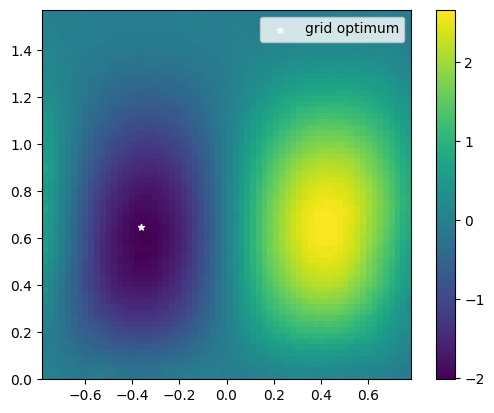

In [8]:
from oscar import CSReconstructor, plot_2d_landscape

reconstructor = CSReconstructor()
landscape.reconstruct(reconstructor)
figure = plot_2d_landscape(landscape)

Uncomment to run the true landscape and compare. (May take some time)

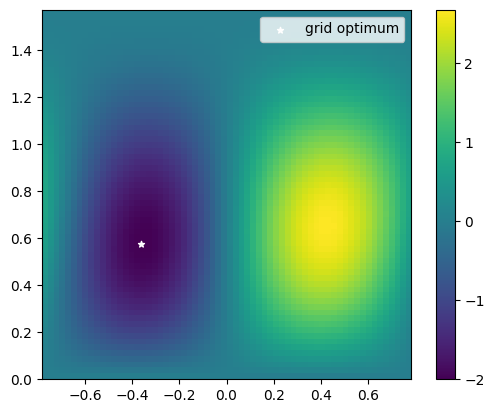

In [11]:
# may take some time
# exact_landscape = Landscape.like(landscape)
# exact_landscape.run_all(qiskit_executor)
# figure = plot_2d_landscape(exact_landscape)

Landscapes can be easily saved for later retrieval.

In [10]:
filename = f"../data/landscapes/p=1-{n=}-{bounds}-{resolution}.pckl"
landscape.save(filename)
landscape = Landscape.load(filename)

### Interpolation
OSCAR can interpolate the grid points to get a continuous approximation of the landscape, which can in turn serve as an executor for optimizers and other purposes.

Total evaluation time: 0.008214473724365234
Optimal parameters reported: [-0.37634738  0.52359878]
Optimal value reported: -1.9860862499074545
Number of evaluations: 47


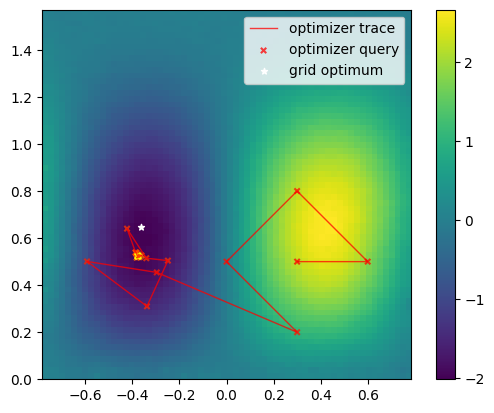

In [11]:
from oscar import InterpolatedLandscapeExecutor, NLoptOptimizer

landscape.interpolate(method="slinear", fill_value=3)
itpl_executor = InterpolatedLandscapeExecutor(landscape)


def optimize_and_show(executor):
    trace, original_result = NLoptOptimizer("LN_BOBYQA", xtol_abs=1e-8, initial_step=0.3).run(
        executor, initial_point=[0.3, 0.5], bounds=bounds
    )
    trace.print_result()
    plot_2d_landscape(landscape, trace)


optimize_and_show(itpl_executor)

Compare with the optimization where the values are calculated by actual circuit executions.

Total evaluation time: 0.3193323612213135
Optimal parameters reported: [-0.35858474  0.58145783]
Optimal value reported: -2.0069211977681123
Number of evaluations: 46


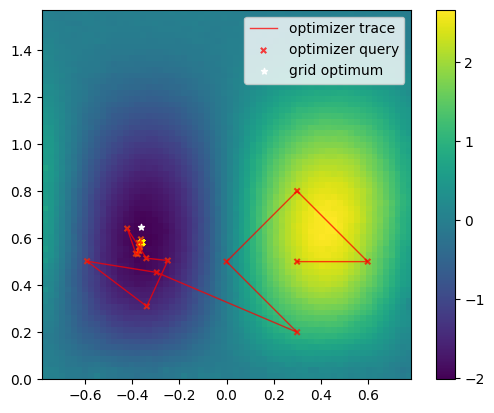

In [12]:
optimize_and_show(qiskit_executor)

We see that the results are very close, while the time for optimizing with the interpolated landscape is negligible compared to the actual optimization, especially when the problem size is large.

### Optimization Configuration Benchmarking
We can specify combinations of hyperparameter values with `oscar.HyperparameterGrid` or `oscar.HyperparameterSet` and then utilize `oscar.HyperparameterTuner` to conveniently do a grid search over all combinations. If a landscape object is available, we can take advantage of the interpolated executor to reduce the grid search time to seconds.

In [13]:
from math import prod
from time import time
from oscar import HyperparameterTuner, HyperparameterGrid, result_metrics, QiskitOptimizer

x0_pool = [(0, 0.6), (0.4, 0.6), (0, 1.2), (-0.4, 1.2), (0.4, 1.2)]
maxfev_pool = [10, 30, 50]
initial_step_pool = [0.001, 0.01, 0.1]
optimizer_configs = [
    HyperparameterGrid(
        NLoptOptimizer,
        optimizer=("LN_COBYLA", "LN_BOBYQA"),
        maxiter=maxfev_pool,
        initial_step=initial_step_pool,
        ftol_rel=[1e-12],
    ),
]
run_configs = HyperparameterGrid(
        executor=[itpl_executor],
        initial_point=x0_pool,
        bounds=[bounds],
    )

tuner = HyperparameterTuner(optimizer_configs)
print(f"Running {prod(prod(config.shape) for config in optimizer_configs + [run_configs])} optimizations...")
start = time()
tuner.run(run_configs)
print(f"...in {time() - start:.2f} seconds.")

Running 90 optimizations...
...in 1.57 seconds.


Print out top optimizer configurations using the optimizer reported optimal value (energy) as the metric.

In [19]:
import numpy as np

result = tuner.process_results(result_metrics.optimal_value())[0]
indices = np.argsort(result.flat)[:5:]
top_configs = tuner.interpret(indices, run_configs=run_configs)
for i, index in enumerate(indices):
    print(f"Energy: {result.flat[index]}  Config: {top_configs[i]}")

Energy: -2.0152383123301854  Config: ['optimizer=LN_COBYLA', 'maxiter=30', 'initial_step=0.001', 'initial_point=(-0.4, 1.2)']
Energy: -2.0152383123301854  Config: ['optimizer=LN_COBYLA', 'maxiter=10', 'initial_step=0.001', 'initial_point=(-0.4, 1.2)']
Energy: -2.0152383123301854  Config: ['optimizer=LN_COBYLA', 'maxiter=50', 'initial_step=0.001', 'initial_point=(-0.4, 1.2)']
Energy: -2.015238312326499  Config: ['optimizer=LN_BOBYQA', 'maxiter=30', 'initial_step=0.001', 'initial_point=(0, 1.2)']
Energy: -2.015238312326499  Config: ['optimizer=LN_BOBYQA', 'maxiter=50', 'initial_step=0.001', 'initial_point=(0, 1.2)']
